# Nucleosome Positioning Analysis

This notebook calculates nucleosome positions and occupancy using energy-based models.

In [220]:
import re, random
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm

## Function Definitions

Core functions for nucleosome positioning calculations.

In [ ]:
FOOTPRINT = 147
SMOOTH_WINDOW = 10
OCCUPANCY_KERNEL = 146

_ASCII_TO_IDX = np.full(256, -1, dtype=np.int8)
_ASCII_TO_IDX[ord("A")] = 0
_ASCII_TO_IDX[ord("C")] = 1
_ASCII_TO_IDX[ord("G")] = 2
_ASCII_TO_IDX[ord("T")] = 3


@dataclass(frozen=True)
class NucPositionResult:
    energy_raw: np.ndarray
    energy_smoothed: np.ndarray
    dyad_probability: np.ndarray
    occupancy: np.ndarray


def CleanSeq(dna: str) -> str:
    """Remove non-GATC characters to prevent energy calculation errors."""
    dna = dna.upper().replace("U", "T")
    return re.sub(r"[^GATC]", "", dna)


def encode_seq(seq: str) -> np.ndarray:
    """Convert to numeric indices for vectorized computation."""
    b = np.frombuffer(seq.encode("ascii"), dtype=np.uint8)
    return _ASCII_TO_IDX[b]


def getweight(w: int, p: float, b: float) -> np.ndarray:
    """Generate position-dependent dinucleotide weights to model DNA bendability."""
    x = np.arange(w, dtype=np.float64)
    s = b * np.sin(2 * np.pi * x / p)
    weights = np.empty((4, 4, w), dtype=np.float64)
    weights[0, 0] = 0.25 + s
    weights[0, 1] = 0.25 - s / 3
    weights[0, 2] = 0.25 - s / 3
    weights[0, 3] = 0.25 - s / 3
    weights[1, 0] = 0.25
    weights[1, 1] = 0.25
    weights[1, 2] = 0.25
    weights[1, 3] = 0.25
    weights[2, 0] = 0.25 + s / 3
    weights[2, 1] = 0.25 - s
    weights[2, 2] = 0.25 + s / 3
    weights[2, 3] = 0.25 + s / 3
    weights[3, 0] = 0.25 + s
    weights[3, 1] = 0.25 - s
    weights[3, 2] = 0.25 - s
    weights[3, 3] = 0.25 + s
    return weights


def calcE(seq: str, w: int, amplitude: float, period: float) -> np.ndarray:
    """Compute energy landscape by accounting for both forward and reverse strand binding."""
    idx = encode_seq(seq)
    L = idx.size
    num_win = L - w
    if num_win <= 0:
        return np.array([], dtype=np.float64)
    weights = getweight(w, period, amplitude)
    log_weights = np.log(np.clip(weights, 1e-300, None))
    log_p_f = np.zeros(num_win, dtype=np.float64)
    log_p_r = np.zeros(num_win, dtype=np.float64)
    i = np.arange(num_win)
    for s in range(w):
        prev_f = idx[i + s - 1]
        curr_f = idx[i + s]
        log_p_f += log_weights[prev_f, curr_f, s]
        a = idx[i + w - s]
        b = idx[i + w - s - 1]
        rprev = 3 - a
        rcurr = 3 - b
        log_p_r += log_weights[rprev, rcurr, s]
    p_f = np.exp(log_p_f) * (4.0**w)
    p_r = np.exp(log_p_r) * (4.0**w)
    p_r = np.roll(p_r, -1)
    E = (p_r * np.log(p_r) + p_f * np.log(p_f)) / (p_r + p_f)
    return E


def smooth(x: np.ndarray, window_len: int) -> np.ndarray:
    """Reduce noise while preserving peak positions."""
    if window_len <= 1 or x.size == 0:
        return x
    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-1:-window_len:-1]]
    w = np.ones(window_len, dtype=np.float64)
    y = np.convolve(w / w.sum(), s, mode="valid")
    return y[
        len(x[window_len - 1 : 0 : -1]) : len(x[window_len - 1 : 0 : -1]) + len(x) + 1
    ]


def vanderlick(Energy: np.ndarray, mu: float, footprint: int) -> np.ndarray:
    """Compute equilibrium dyad probability accounting for steric exclusion between nucleosomes."""
    E_out = Energy - mu
    n = E_out.size
    forward = np.zeros(n, dtype=np.float64)
    sum_prev = 0.0
    for i in range(n):
        forward[i] = np.exp(E_out[i] - sum_prev)
        sum_prev += forward[i]
        if i >= footprint:
            sum_prev -= forward[i - footprint]
    backward = np.zeros(n, dtype=np.float64)
    r_forward = forward[::-1]
    sum_prod = 0.0
    for i in range(n):
        backward[i] = 1.0 - sum_prod
        sum_prod += r_forward[i] * backward[i]
        if i >= footprint:
            sum_prod -= r_forward[i - footprint] * backward[i - footprint]
    return forward * backward[::-1]


def CalcNucPositions(
    sequence: str, w: int, chemical_potential: float, amplitude: float, period: float
) -> NucPositionResult:
    """Pipeline combining all steps to generate final nucleosome positioning prediction."""
    sequence = CleanSeq(sequence)
    energy_raw = calcE(sequence, w, amplitude, period)
    energy_smoothed = smooth(energy_raw, SMOOTH_WINDOW)
    dyad_probability = vanderlick(energy_smoothed, chemical_potential, w)
    left_pad = (w + 1) // 2
    right_pad = w // 2
    dyad_probability = np.concatenate(
        (
            np.zeros(left_pad, dtype=np.float64),
            dyad_probability,
            np.zeros(right_pad, dtype=np.float64),
        )
    )
    occupancy = np.convolve(
        dyad_probability, np.ones(OCCUPANCY_KERNEL, dtype=np.float64), mode="same"
    )
    return NucPositionResult(energy_raw, energy_smoothed, dyad_probability, occupancy)


def create_sequence(contour_length, dyads_601=None):
    """Generate test sequences with known positioning elements for validation."""
    sequence = np.random.choice(list("ACGT"), contour_length)

    if dyads_601 is not None:
        sequence_601 = list(
            "ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG"
        )
        for dyad in dyads_601:
            start_index = max(0, dyad - len(sequence_601) // 2)
            end_index = min(contour_length, dyad + len(sequence_601) // 2)
            length = end_index - start_index
            sequence[start_index : start_index + length] = sequence_601[:length]

    sequence = "".join(sequence)
    return sequence


def sample_fiber_configuration(dyad_probability: np.ndarray, footprint: int = FOOTPRINT) -> np.ndarray:
    """
    Stochastically sample a single nucleosome arrangement to generate ensemble statistics.
    
    Edge regions are excluded to prevent boundary artifacts from biasing occupancy.
    """
    p = dyad_probability.copy()
    p[:FOOTPRINT//2] = 0
    p[-FOOTPRINT//2:] = 0
    nucs = np.zeros_like(dyad_probability)
    dyads_sampled = []
    
    # Pre-compute values
    num_nucleosomes = int(np.sum(dyad_probability))+1
    half_footprint = footprint // 2
    seq_length = len(dyad_probability)
    
    for _ in range(num_nucleosomes):
        # Check if any probability remains
        p_sum = np.sum(p)
        if p_sum <= 0:
            break
            
        # Sample a dyad position
        dyad_pos = np.random.choice(seq_length, p=p/p_sum)
        dyads_sampled.append(dyad_pos)
        
        # Calculate boundaries - ensure full footprint fits
        nuc_start = dyad_pos - half_footprint
        nuc_end = nuc_start + footprint -1
        
        nucs[nuc_start:nuc_end] = 1
        p[nuc_start:nuc_end] = 0  

    return nucs


def plot_results(dyads = None, dyad_probability = None, occupancy = None, nucs = None):
    """Visualize multiple layers of positioning data for comparison."""
    plt.figure(figsize=(15, 3))
    
    if dyad_probability is not None:
        plt.plot(dyad_probability * 1e1, label="Probability", color="blue")
    if occupancy is not None:
        plt.plot(occupancy, label="Occupancy", color="red")
    if dyads is not None:
        plt.vlines(dyads, 0, 1, colors="grey", linestyles="dashed", label="601 Dyads", alpha=0.5)
    if nucs is not None:
        x = np.arange(len(nucs))
        plt.fill_between(x, 0, nucs, alpha=0.1, color="blue", label="Nucleosomes")
        
    plt.xlabel("i (bp)")
    plt.ylabel("Probability / Occupancy")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    # plt.show()

## Generate Test Sequence

Create a random DNA sequence with optional 601 positioning sequences embedded at specific positions.

In [23]:
contour_length = 5000

# Optionally add 601 sequences
handle_length = 1000
dyads_601 = np.arange(handle_length, contour_length - handle_length, 197)

## Visualize Results

Plot the dyad probability and nucleosome occupancy with vertical lines showing the 601 dyad positions.

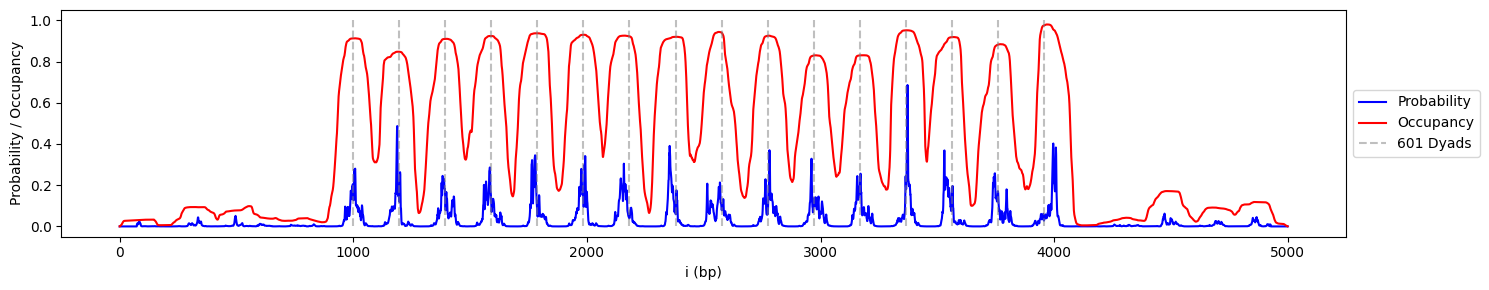

In [247]:
sequence = create_sequence(contour_length, dyads_601)
result = CalcNucPositions(
    sequence, 
    FOOTPRINT, 
    chemical_potential=-1.5, 
    amplitude=0.2, 
    period=10.0
)

plot_results(dyads=dyads_601, dyad_probability=result.dyad_probability, occupancy=result.occupancy)


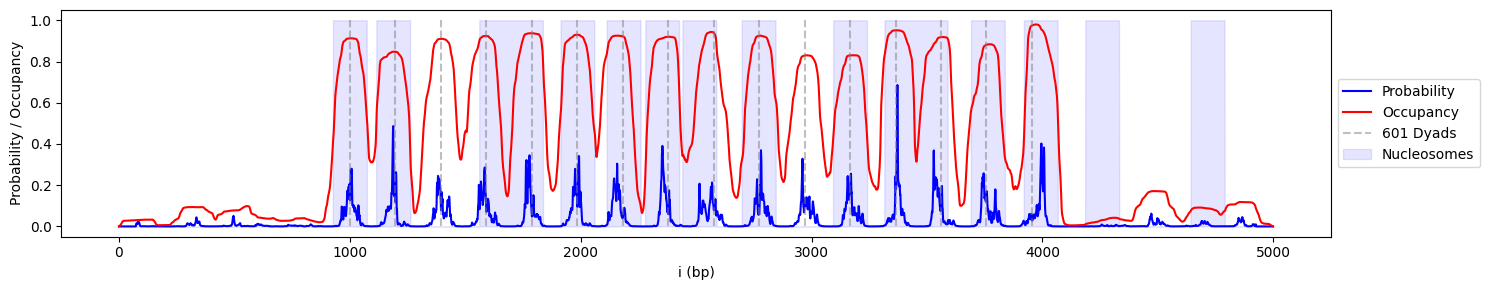

In [248]:
nucs = sample_fiber_configuration(result.dyad_probability, FOOTPRINT)

plot_results(dyads=dyads_601, dyad_probability=result.dyad_probability, occupancy=result.occupancy, nucs=nucs)


100%|██████████| 10000/10000 [00:16<00:00, 593.75it/s]



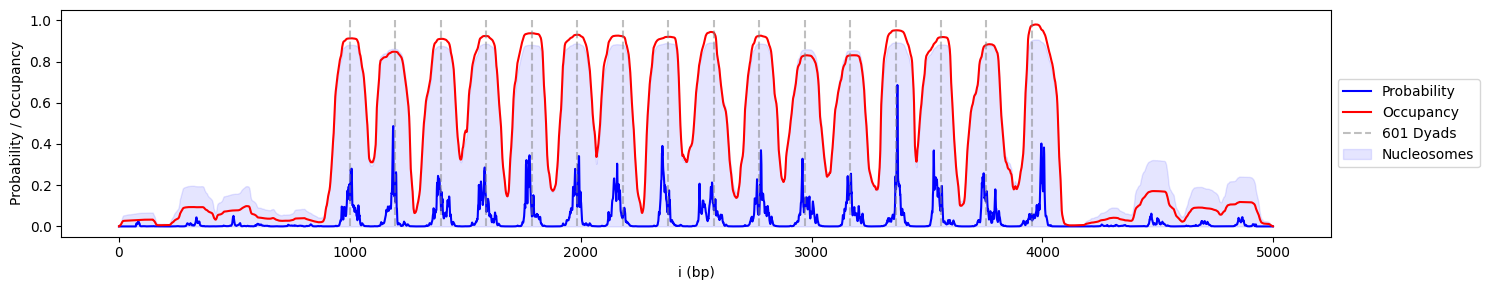

In [253]:
nucs = np.zeros_like(result.dyad_probability)

n = 1e4
for _ in tqdm(range(int(n))):
    nucs += sample_fiber_configuration(result.dyad_probability, FOOTPRINT)
nucs /= n

plot_results(dyads=dyads_601, dyad_probability=result.dyad_probability, occupancy=result.occupancy, nucs=nucs)